In [4]:
import os
import numpy as np
import pandas as pd
from scipy import stats

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [6]:
df = pd.read_csv("throughput_logs.csv")
df.count()

file_name            102895
network_name         102815
p1                   102895
p2                   102895
p3                   102860
p4                   102841
p5                   102808
p6                   102793
p7                   102760
p8                   102727
p9                   102674
p10                  102492
p11                  100247
p12                   99495
p13                   99040
p14                   96829
p15                   94614
p16                   93660
p17                   91847
p18                   88739
mean_throughput      102895
median_throughput    102895
stdv_throughput      102895
p19                   86724
p20                   84687
p21                   82637
p22                   80637
p23                   78730
p24                   76797
p25                   75035
p26                   73444
p27                   71678
p28                   68850
p29                   66945
p30                   65664
dtype: int64

In [7]:
df.network_name.value_counts()

xsede        74261
dtns         19205
esnet         6849
pronghorn     2500
Name: network_name, dtype: int64

In [243]:
data = df[df.network_name=='xsede'][['p2', 'p3', 'p4', 'p5', 'p6','p7', 'p8', 'p9', 'p10', 'p11', 'mean_throughput']]
data = data[((data>data.quantile(0.2)) & (data<data.quantile(0.8))).all(axis=1)]
# data = data[(data>300) & (data<15000)]
data.dropna(inplace=True)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p2,14577.0,529.123909,236.622763,141.977190,333.447168,515.899392,711.983104,1030.750208
p3,14577.0,1872.746809,676.103426,467.664896,1342.177280,1983.905792,2392.850432,3303.014400
p4,14577.0,1888.470773,627.199391,480.247808,1409.286144,1971.322880,2363.490304,3223.322624
p5,14577.0,2000.051863,590.605813,629.145600,1551.892480,2069.889024,2420.113408,3395.289088
p6,14577.0,2166.900251,555.488998,952.107008,1772.093440,2181.038080,2478.833664,3909.091328
p7,14577.0,2355.358355,609.373946,1105.199104,1946.157056,2304.770048,2684.354560,4479.516672
p8,14577.0,2495.857037,694.860803,1279.262720,2032.140288,2369.781760,2852.126720,5274.337280
p9,14577.0,2580.185652,772.977973,1369.440256,2065.694720,2411.724800,2959.081472,5838.471168
p10,14577.0,2645.791104,841.710265,1444.937728,2097.152000,2432.696320,3021.996032,6251.610112
p11,14577.0,2681.336370,898.711636,1398.800384,2099.249152,2449.473536,3047.161856,6488.588288


## Pairwise Relationships

In [244]:
# sns.pairplot(data[["p2", "p3", "p4", "mean_throughput"]], diag_kind="kde")
# plt.show()

data.corr()

,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,mean_throughput
p2,1.000000,0.451441,0.398820,0.358084,0.247479,0.075603,-0.013320,-0.037889,-0.046998,-0.063105,-0.027596
p3,0.451441,1.000000,0.847638,0.719627,0.498626,0.193509,0.018524,-0.037234,-0.074706,-0.096483,-0.084826
p4,0.398820,0.847638,1.000000,0.808639,0.565938,0.257681,0.070765,0.006572,-0.035181,-0.059734,-0.033748
p5,0.358084,0.719627,0.808639,1.000000,0.703049,0.387803,0.187225,0.099276,0.055188,0.023414,0.068384
p6,0.247479,0.498626,0.565938,0.703049,1.000000,0.645124,0.430038,0.309368,0.247253,0.206982,0.283851
p7,0.075603,0.193509,0.257681,0.387803,0.645124,1.000000,0.691245,0.540825,0.455083,0.407817,0.512572
p8,-0.013320,0.018524,0.070765,0.187225,0.430038,0.691245,1.000000,0.725468,0.619242,0.565637,0.676634
p9,-0.037889,-0.037234,0.006572,0.099276,0.309368,0.540825,0.725468,1.000000,0.722988,0.657954,0.758258
p10,-0.046998,-0.074706,-0.035181,0.055188,0.247253,0.455083,0.619242,0.722988,1.000000,0.717007,0.776576
p11,-0.063105,-0.096483,-0.059734,0.023414,0.206982,0.407817,0.565637,0.657954,0.717007,1.000000,0.793531


## Train and Test Data

In [245]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [246]:
train_stats = train_dataset.describe()
train_stats.pop("mean_throughput")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
p2,11662.0,529.102934,236.512019,141.977190,334.338458,515.899392,710.934528,1030.750208
p3,11662.0,1868.302221,675.107766,467.664896,1342.177280,1977.614336,2392.850432,3303.014400
p4,11662.0,1884.793511,626.420681,480.247808,1409.286144,1966.080000,2359.296000,3223.322624
p5,11662.0,1997.580259,589.814206,633.339904,1551.892480,2067.791872,2418.016256,3393.191936
p6,11662.0,2165.220785,556.308462,952.107008,1769.996288,2181.038080,2474.639360,3909.091328
p7,11662.0,2356.356355,611.114413,1105.199104,1946.157056,2300.575744,2681.733120,4479.516672
p8,11662.0,2493.349006,694.345356,1279.262720,2030.567424,2365.587456,2847.932416,5274.337280
p9,11662.0,2581.211978,776.944087,1369.440256,2065.694720,2411.724800,2961.178624,5838.471168
p10,11662.0,2644.988273,844.096269,1444.937728,2097.152000,2432.696320,3024.093184,6251.610112
p11,11662.0,2678.130180,899.366084,1398.800384,2097.152000,2447.376384,3040.870400,6488.588288


In [247]:
train_labels = train_dataset.pop('mean_throughput')
test_labels = test_dataset.pop('mean_throughput')

## Normalization

In [248]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Model

In [249]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [250]:
model = build_model()
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_96 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_97 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Training

In [219]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [220]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,100447.329927,209.991272,100447.289062,184381.650961,269.770905,184381.609375,995
996,100896.441608,210.526428,100896.445312,179707.365517,276.368500,179707.390625,996
997,100893.997029,210.426666,100894.023438,178667.501209,267.855499,178667.531250,997
998,100805.453443,210.238052,100805.414062,183517.699544,271.666107,183517.640625,998
999,100726.513025,210.357544,100726.492188,177691.177821,271.865082,177691.171875,999


<Figure size 432x288 with 0 Axes>

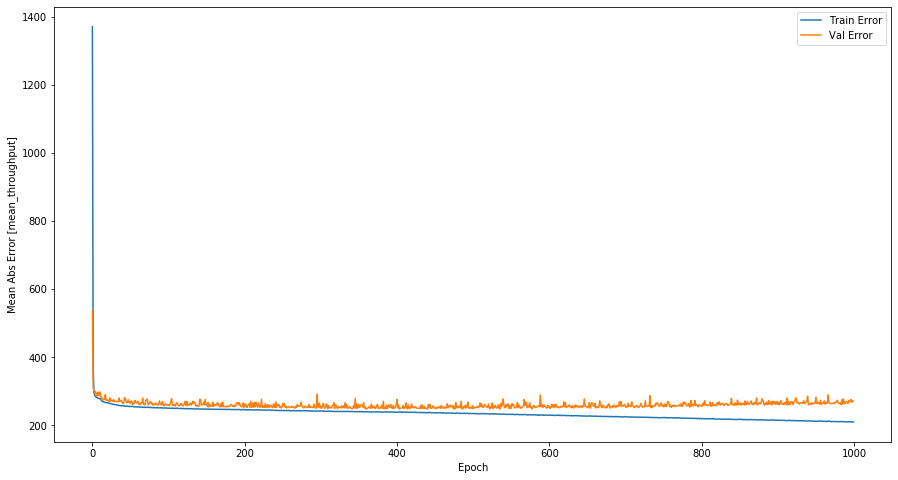

<Figure size 432x288 with 0 Axes>

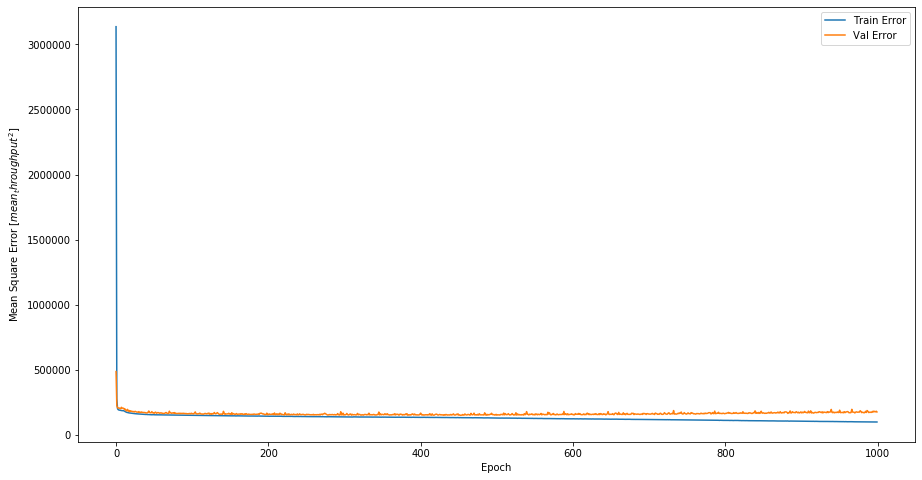

In [221]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [mean_throughput]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$mean_throughput^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show();


plot_history(history)

## Training - Early Terminations if Possible


...........................................

<Figure size 432x288 with 0 Axes>

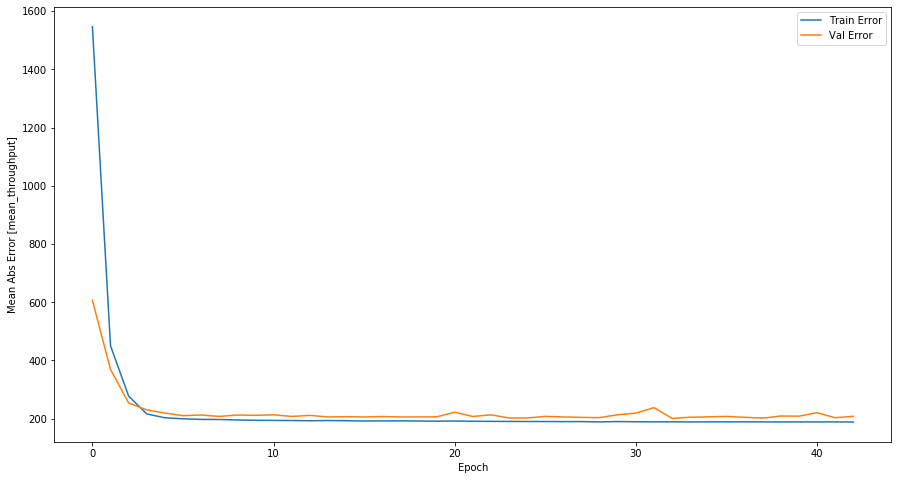

<Figure size 432x288 with 0 Axes>

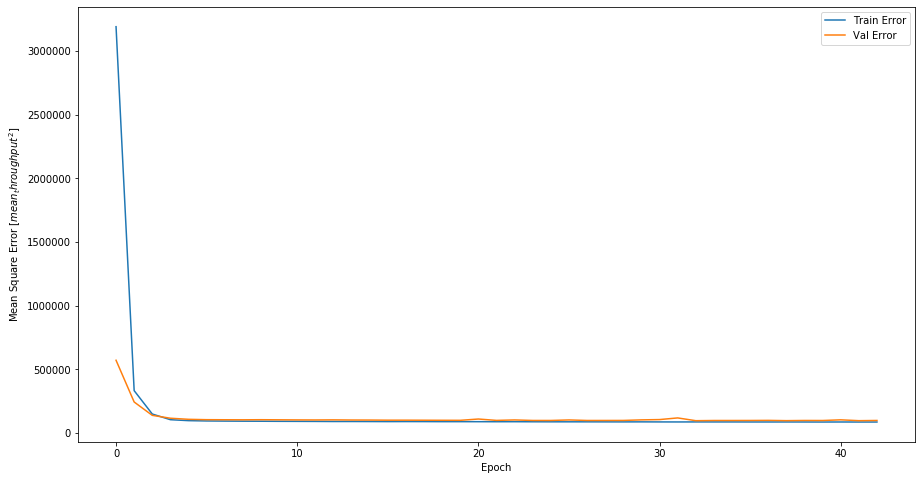

In [251]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Output

In [252]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 200.52


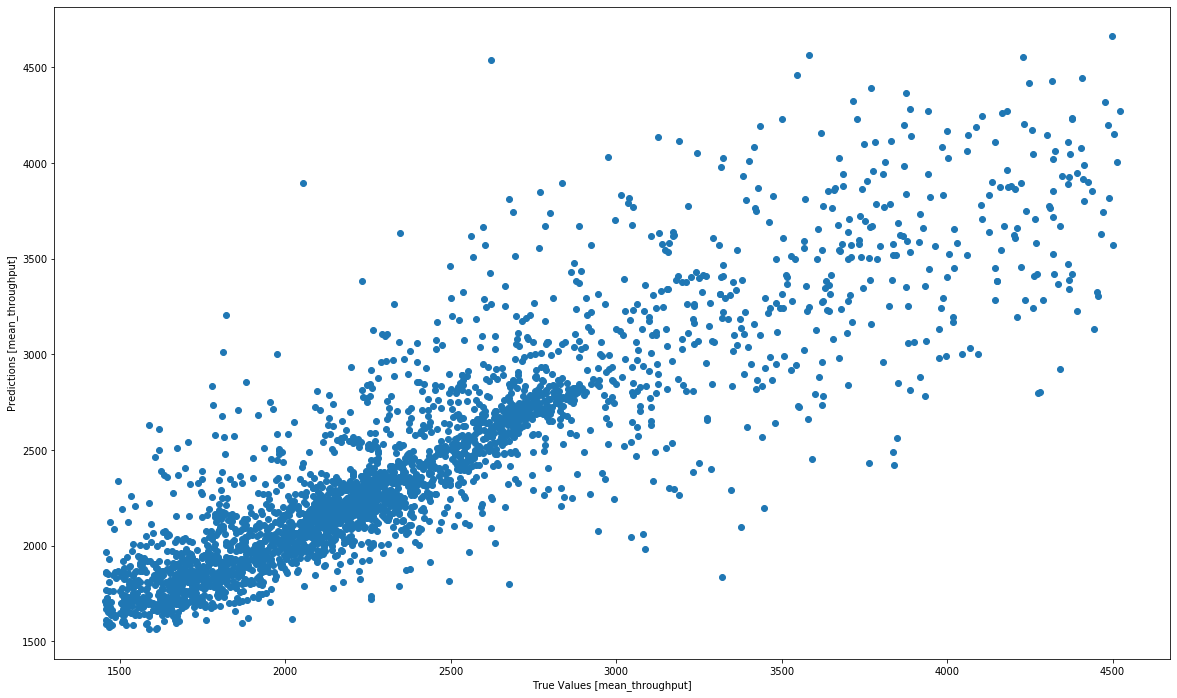

In [253]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(20,12))
plt.xlabel('True Values [mean_throughput]')
plt.ylabel('Predictions [mean_throughput]')
plt.scatter(test_labels, test_predictions)
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
plt.show()
# _ = plt.plot([0, 0], [-100, 100])

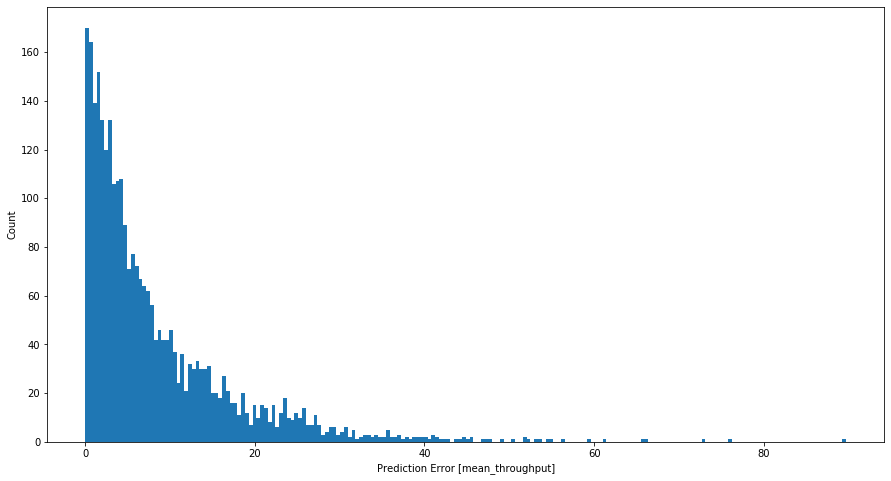

In [254]:
error = np.abs((test_predictions - test_labels)/test_labels) * 100
plt.figure(figsize=(15,8))
plt.hist(error, bins = 200)
plt.xlabel("Prediction Error [mean_throughput]")
_ = plt.ylabel("Count")

#### Error Rate

In [255]:
np.round(np.mean(error), 2)

8.36

#### Error Distribution

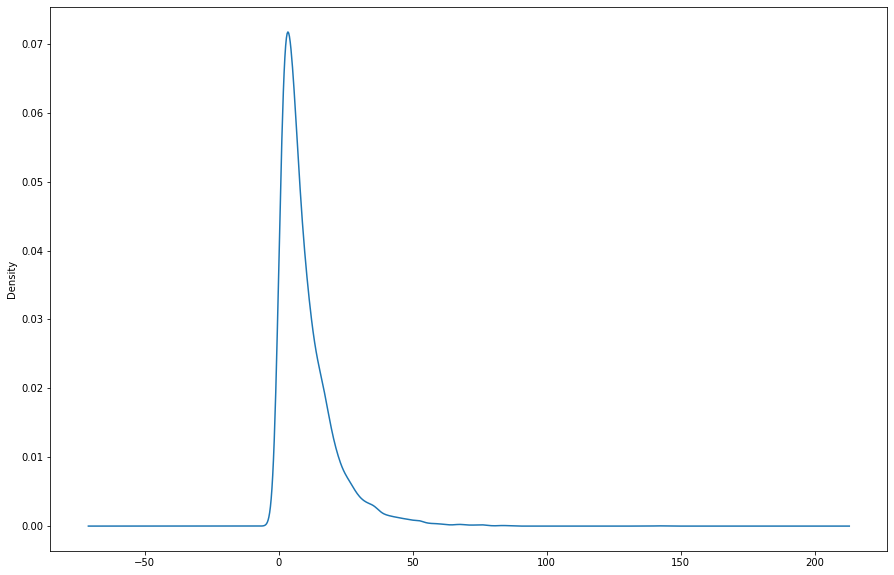

In [204]:
plt.figure(figsize=(15,10))
error.plot.kde();

#### Worst performing Data Points

In [208]:
error[error>50]

1804       52.215039
9051       52.119793
9773       74.977823
9847       61.656851
10762      50.269319
10856      58.569729
10905      56.428560
11090      58.207328
12069      52.305136
12265      69.031597
12847      71.877645
13546      56.314894
13614      53.683619
13955      67.172071
14144      85.313644
14527      66.522708
15074      50.160631
15246      52.235280
15998      67.644324
16388      55.093239
16500      52.725289
17213      51.401634
17268      62.897235
25771      50.809938
28039      53.591187
28537      56.286936
28616      52.288527
29046      72.304850
30440      53.530073
31507      63.472873
             ...    
48779      76.487972
75507      61.304143
75809      83.362718
76122      52.639937
76232      70.842818
76872      50.666741
76998      51.792357
77559      64.922173
77858      76.054900
78243      52.509108
80028      82.897121
84405      69.035852
84567      55.216591
84661      59.362520
85532      67.916873
86010      55.424560
86799      52

In [209]:
data.loc[error[error>50].index,:]

,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,mean_throughput
1804,709.885952,2774.532096,1644.167168,1608.515584,1470.103552,1212.153856,1604.321280,2155.872256,2728.394752,2627.731456,1370.272126
9051,130.023424,293.601280,339.738624,522.190848,861.929472,1421.869056,2176.843776,2583.691264,3902.799872,4687.134720,1878.034569
9773,241.871531,952.107008,1010.827264,1119.879168,1304.428544,1581.252608,1895.825408,2281.701376,2915.041280,3393.191936,1540.591161
9847,85.983232,234.881024,285.212672,398.458880,673.185792,1140.850688,1818.230784,2694.840320,1172.307968,4143.972352,1633.471693
10762,81.369498,843.055104,882.900992,975.175680,1140.850688,1405.091840,1732.247552,1203.765248,2940.207104,3068.133376,1477.569413
10856,160.781653,629.145600,683.671552,780.140544,964.689920,1251.999744,1608.515584,2189.426688,3124.756480,3351.248896,1549.177833
10905,207.618048,440.401920,503.316480,679.477248,1054.867456,1612.709888,2388.656128,1495.269376,3181.379584,5408.555008,2005.681220
11090,232.084821,1017.118720,1084.227584,1319.108608,1746.927616,2726.297600,3722.444800,4867.489792,3007.315968,2671.771648,1940.331634
12069,270.532608,662.700032,721.420288,830.472192,1040.187392,1312.817152,1686.110208,1795.162112,2489.319424,3212.836864,1633.611503
12265,148.897792,450.887680,526.385152,742.391808,1140.850688,1717.567488,2480.930816,1233.125376,3930.062848,4659.871744,1584.817766
